# Tarea 2: Piping y Bombas
### Pablo Correa e Ian Gross

## Librerías

In [1]:
import CoolProp.CoolProp as cp
import fluids as fld
import numpy as np
import scipy.constants as cte
import matplotlib.pyplot as plt

from fluids.units import *

In [2]:
g = cte.g*u.m/u.s**2

## Problema 1

Considere el sistema de distribución de agua en la figura, donde la presión en A es 150 psig.

Considerando las tuberías de entrada y salida 1 y 2 respectivamente, y las tuberías paralelas A, B y C desde arriba hacia abajo, se tiene que:

In [3]:
# datos
z_A = (100*u.ft).to(u.m)
z_B = (120*u.ft).to(u.m)

L_1 = (2000*u.ft).to(u.m)
L_2 = (4000*u.ft).to(u.m)
L_A = (3000*u.ft).to(u.m)
L_B = (2000*u.ft).to(u.m)
L_C = (3000*u.ft).to(u.m)

D_1 = (24*u.inch).to(u.m)
D_2 = (30*u.inch).to(u.m)
D_A = (14*u.inch).to(u.m)
D_B = (12*u.inch).to(u.m)
D_C = (16*u.inch).to(u.m)

A_1 = np.pi * D_1**2 / 4
A_2 = np.pi * D_2**2 / 4
A_A = np.pi * D_A**2 / 4
A_B = np.pi * D_B**2 / 4
A_C = np.pi * D_C**2 / 4

Q = (20*u.cubic_feet/u.s).to(u.m**3/u.s)
P_1 = ((150 + 14.7)*u.psi).to(u.Pa) # psig = psi + 14.7
T = 300*u.K # Asumiendo temperatura ambiente
epsilon = (0.0015*u.mm).to(u.m) # Asumiendo tubería de PVC [1]

rho = cp.PropsSI('D', 'P', P_1.magnitude, 'T', T.magnitude, 'Water')*u.kg/u.m**3
mu = cp.PropsSI('V', 'P', P_1.magnitude, 'T', T.magnitude, 'Water')*u.Pa*u.s

a. La pérdida de carga desde A a B, si es que solo la tubería A es utilizada.

Considerando que solo se usa la tubería A, los caudales serían:

$$\dot{\forall} = \dot{\forall}_1 = \dot{\forall}_2 = \dot{\forall}_A$$
$$\dot{\forall}_B = \dot{\forall}_C = 0$$

Además, se sabe que las pérdidas de carga corresponderían a las pérdidas por fricción en los tramos y no hay singularidades, por lo tanto:

$$\Delta P = \Delta P_1 + \Delta P_2 + \Delta P_A$$
$$\Delta P_i = f_i \rho \frac{L_i}{D_i} \frac{V_i^2}{2}$$

Siendo $V_i$ la velocidad promedio en el tramo. Suponiendo que el caudal es constante a lo largo del tramo, y que las tuberías tienen perfil circular, se puede estimar que las velocidades serían:

$$V_i = \frac{\dot{\forall}_i}{A_i} = \frac{4 \dot{\forall}}{\pi D_i^2}$$

Con esta expresión, la pérdida total sería

$$\Delta P = \frac{\rho}{2} (f_1 \frac{L_1}{D_1} V_1^2 + f_2 \frac{L_2}{D_2} V_2^2 + f_A \frac{L_A}{D_A} V_A^2)$$

In [4]:
v_1 = Q / A_1
v_2 = Q / A_2
v_A = Q / A_A

Re_1 = fld.Reynolds(D=D_1, rho=rho, mu=mu, V=v_1)
Re_2 = fld.Reynolds(D=D_2, rho=rho, mu=mu, V=v_2)
Re_A = fld.Reynolds(D=D_A, rho=rho, mu=mu, V=v_A)

f_1 = fld.friction.friction_factor(Re_1, eD=epsilon/D_1)
f_2 = fld.friction.friction_factor(Re_2, eD=epsilon/D_2)
f_A = fld.friction.friction_factor(Re_A, eD=epsilon/D_A)

DP_1 = rho/2*(f_1*L_1/D_1*v_1**2 + f_A*L_A/D_A*v_A**2 + f_2*L_2/D_2*v_2**2 + g*(z_B - z_A))
print(f"La pérdida de carga total es {DP_1.to(u.kPa)}")

La pérdida de carga total es 492.57903720404875 kilopascal


b. La pérdida de carga desde A a B, si es que las tuberías A y B son utilizadas.

Considerando que se usan las tuberías A y B, se puede suponer que los caudales tienen las siguientes relaciones:

$$\dot{\forall} = \dot{\forall}_A + \dot{\forall}_B$$
$$\dot{\forall}_C = 0$$

Por otro lado, como las tuberías se encuentran paralelas se sabe que:

$$\Delta P_A = \Delta P_B$$
$$\Delta P_A - \Delta P_B = 0$$

Reemplazando las expresiones de velocidad y presión de la parte (a.) se tiene que:

$$A_A V_A + A_B V_B = \dot{\forall}$$
$$f_A \frac{\rho}{2} \frac{L_A}{D_A} V_A^2 - f_B \frac{\rho}{2} \frac{L_B}{D_B} V_B^2 = 0$$

Se da un ansatz de la distribución inicial de caudales. Luego, se itera sobre estos valores hasta llegar a un resultado parejo.

In [5]:
# Ansatz e iteración manual. Asegurando la conservación del caudal.
x = 0.546366
Q_A = x*Q
Q_B = (1-x)*Q

v_1 = Q / A_1
v_2 = Q / A_2
v_A = Q_A / A_A
v_B = Q_B / A_B

Re_1 = fld.Reynolds(D=D_1, rho=rho, mu=mu, V=v_1)
Re_2 = fld.Reynolds(D=D_2, rho=rho, mu=mu, V=v_2)
Re_A = fld.Reynolds(D=D_A, rho=rho, mu=mu, V=v_A)
Re_B = fld.Reynolds(D=D_B, rho=rho, mu=mu, V=v_B)

f_1 = fld.friction.friction_factor(Re_1, eD=epsilon/D_1)
f_2 = fld.friction.friction_factor(Re_2, eD=epsilon/D_2)
f_A = fld.friction.friction_factor(Re_A, eD=epsilon/D_A)
f_B = fld.friction.friction_factor(Re_B, eD=epsilon/D_B)

# Se debe dar igualdad de presiones para A y B
P_A = rho*f_A*L_A/D_A*v_A**2/2
P_B = rho*f_B*L_B/D_B*v_B**2/2

print(f"La pérdida de carga en A es {P_A.to(u.Pa)}")
print(f"La pérdida de carga en B es {P_B.to(u.Pa)}")
print(f"La diferencia de presiones es {(P_A - P_B).to(u.Pa)}")

La pérdida de carga en A es 140123.58084382655 pascal
La pérdida de carga en B es 140123.42375500116 pascal
La diferencia de presiones es 0.15708882539183833 pascal


In [6]:
# Sumando las pérdidas de carga 1 y 2 y la diferencia de alturas
DP_2 = rho/2*(f_1*L_1/D_1*v_1**2 + f_A*L_A/D_A*v_A**2 + f_2*L_2/D_2*v_2**2 + g*(z_B - z_A))
print(f"La pérdida de carga total es {DP_2.to(u.kPa)}")

La pérdida de carga total es 204.89246654202438 kilopascal


c. La pérdida de carga desde A a B, si es que las 3 tuberías son utilizadas.

Considerando ahora todas las tuberías, se tiene que:

$$\dot{\forall} = \dot{\forall}_A + \dot{\forall}_B + \dot{\forall}_C$$
$$\Delta P_A = \Delta P_B = \Delta P_C$$

Por lo tanto:

$$\dot{\forall}_A + \dot{\forall}_B + \dot{\forall}_C = \dot{\forall}$$
$$\Delta P_A - \Delta P_B = 0$$
$$\Delta P_A - \Delta P_C = 0$$

Reemplazando las expresiones, se tiene que:

$$A_A V_A + A_B V_B + A_C V_C = \dot{\forall}$$
$$f_A \frac{\rho}{2} \frac{L_A}{D_A} V_A^2 - f_B \frac{\rho}{2} \frac{L_B}{D_B} V_B^2 = 0$$
$$f_A \frac{\rho}{2} \frac{L_A}{D_A} V_A^2 - f_C \frac{\rho}{2} \frac{L_C}{D_C} V_B^2 = 0$$

In [7]:
# Ansatz e iteración manual. Asegurando la conservación del caudal.
x = 0.3073715
y = 0.255237
Q_A = x*Q
Q_B = y*Q
Q_C = (1-x-y)*Q

v_1 = Q / A_1
v_2 = Q / A_2
v_A = Q_A / A_A
v_B = Q_B / A_B
v_C = Q_C / A_C
v_tag = ['v_1', 'v_2', 'v_A', 'v_B', 'v_C']
v = [v_1, v_2, v_A, v_B, v_C]


Re_1 = fld.Reynolds(D=D_1, rho=rho, mu=mu, V=v_1)
Re_2 = fld.Reynolds(D=D_2, rho=rho, mu=mu, V=v_2)
Re_A = fld.Reynolds(D=D_A, rho=rho, mu=mu, V=v_A)
Re_B = fld.Reynolds(D=D_B, rho=rho, mu=mu, V=v_B)
Re_C = fld.Reynolds(D=D_C, rho=rho, mu=mu, V=v_C)

f_1 = fld.friction.friction_factor(Re_1, eD=epsilon/D_1)
f_2 = fld.friction.friction_factor(Re_2, eD=epsilon/D_2)
f_A = fld.friction.friction_factor(Re_A, eD=epsilon/D_A)
f_B = fld.friction.friction_factor(Re_B, eD=epsilon/D_B)
f_C = fld.friction.friction_factor(Re_C, eD=epsilon/D_C)
f = [f_1, f_2, f_A, f_B, f_C]

# Se debe dar igualdad de presiones para A y B
P_A = rho*f_A*L_A/D_A*v_A**2/2
P_B = rho*f_B*L_B/D_B*v_B**2/2
P_C = rho*f_C*L_C/D_C*v_C**2/2

print(f"La presión en A es {P_A.to(u.kPa)}")
print(f"La presión en B es {P_B.to(u.kPa)}")
print(f"La presión en C es {P_C.to(u.kPa)}\n")

print(f"La diferencia de presiones A-B es {(P_A - P_B).to(u.Pa)}")
print(f"La diferencia de presiones A-C es {(P_A - P_C).to(u.Pa)}")
print(f"La diferencia de presiones B-C es {(P_B - P_C).to(u.Pa)}")

La presión en A es 48.76796414776605 kilopascal
La presión en B es 48.76769734585945 kilopascal
La presión en C es 48.76797488749972 kilopascal

La diferencia de presiones A-B es 0.266801906596811 pascal
La diferencia de presiones A-C es -0.010739733668742701 pascal
La diferencia de presiones B-C es -0.2775416402655537 pascal


In [8]:
# Sumando las pérdidas de carga 1 y 2 y la diferencia de alturas
DP_3 = rho/2*(f_1*L_1/D_1*v_1**2 + f_A*L_A/D_A*v_A**2 + f_2*L_2/D_2*v_2**2 + g*(z_B - z_A))
print(f"La pérdida de carga total es {DP_3.to(u.kPa)}")

La pérdida de carga total es 113.53684984596386 kilopascal


d. Determine la potencia requerida (en caballos de fuerza) para hacer la presión en B sea igual
a A, en los 3 ítems anteriores.

In [9]:
P_B_1 = P_A - DP_1
P_B_2 = P_A - DP_2
P_B_3 = P_A - DP_3

hp_1 = P_B_1*Q
hp_2 = P_B_2*Q
hp_3 = P_B_3*Q

print(f"La presión en B calculada con el primer método es {P_B_1}")
print(f"La presión en B calculada con el segundo método es {P_B_2}")
print(f"La presión en B calculada con el tercer método es {P_B_3}\n")

print(f"Caballos de potencia requeridos con el primer método es {hp_1.to(u.hp)}")
print(f"Caballos de potencia requeridos con el segundo método es {hp_2.to(u.hp)}")
print(f"Caballos de potencia requeridos con el tercer método es {hp_3.to(u.hp)}")

La presión en B calculada con el primer método es -443811.07305628265 kilogram / meter / second ** 2
La presión en B calculada con el segundo método es -156124.50239425834 kilogram / meter / second ** 2
La presión en B calculada con el tercer método es -64768.8856981978 kilogram / meter / second ** 2

Caballos de potencia requeridos con el primer método es -337.0613446640282 horsepower
Caballos de potencia requeridos con el segundo método es -118.57192825231168 horsepower
Caballos de potencia requeridos con el tercer método es -49.19004736742283 horsepower


e. A partir de los resultados obtenidos en (d.) ¿Que puede concluir a partir de a utilización de
tubería sen paralelos para sistemas de bombeo?

Las tuberías en paralelo implican que cada tramo de tubería tendrá un menor caudal y, por lo tanto, una menor pérdida por fricción. Por el mismo motivo, más tuberías en paralelo también pueden implicar descebado de la bomba, pues el caudal no es el suficiente para utilizar el área superficial de la tubería.

Por otro lado, el caudal se distribuye en proporción al tamaño de las tuberías y la resistencia que estas impongan al flujo del agua. Las velocidades en cada camino serán diferentes en función de este caudal.

f. Considerando una bomba modelo B3Z-M en el tramo 1 (L=2000ft y D=24in), con un
rodete de 8,438” (Página 45 del catálogo Berkeley). Determinar el caudal de operación en cada
tramo de tubería.

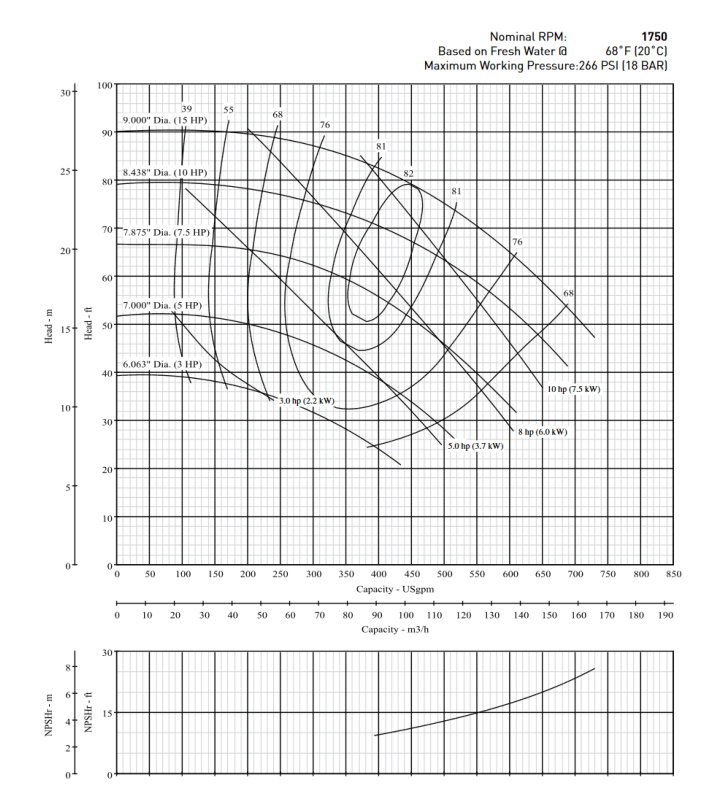

In [10]:
# plt pixmap for image
plt.figure(dpi=250)  # You can set it to any value you prefer, such as 200 or 300
plt.imshow(plt.imread("P1.f.png"))
plt.axis('off')
plt.show()

Utilizando la curva de rodete 8.438".

In [11]:
L = 2000*u.ft
D = 24*u.inch
A = np.pi*D**2/4

for vi in range(len(v)):
    Hp = f[vi]*L/D*v[vi]**2/(2*g)
    print(f"{v_tag[vi]}: {v[vi]}")
    print(f"H: {Hp.to(u.m)}\n")

v_1: 1.940417066176388 meter / second
H: 2.129966327977088 meter

v_2: 1.241866922352888 meter / second
H: 0.9039733687978891 meter

v_A: 1.7527706574060804 meter / second
H: 1.9397032032685133 meter

v_B: 1.9810649228786508 meter / second
H: 2.4938904747285973 meter

v_C: 1.9096243452011015 meter / second
H: 2.216804149065194 meter



g. Considerando la misma bomba usada en (f) pero instalada en el tramo central (L=2000ft y
D=24in). Determinar la distriubución del caudal de operación.

## Problema 2

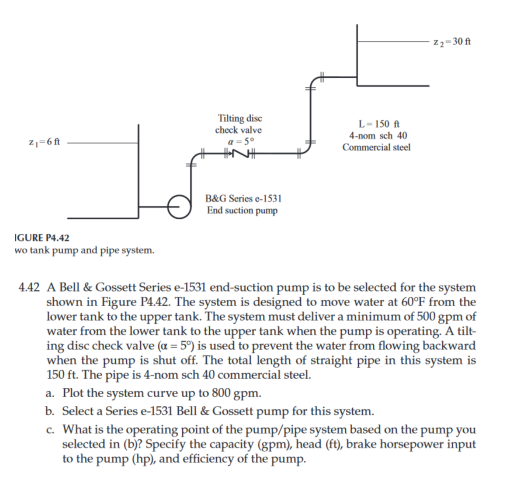

In [12]:
# plt pixmap for image
plt.figure(dpi=150)  # You can set it to any value you prefer, such as 200 or 300
plt.imshow(plt.imread("P2.png"))
plt.axis('off')
plt.show()

In [18]:
T = (60*u.fahrenheit).to(u.K)
P = (1*u.atm).to(u.Pa) # asumimos presion sobre agua en estanque de 1 atm
Q_min = (500*u.gallon/u.min).to(u.m**3/u.s) # caudal

rho = cp.PropsSI('D', 'P', P.magnitude, 'T', T.magnitude, 'Water')*u.kg/u.m**3
mu = cp.PropsSI('V', 'P', P.magnitude, 'T', T.magnitude, 'Water')*u.Pa*u.s

z1 = (6*u.ft).to(u.m)
z2 = (30*u.ft).to(u.m)

L = (150*u.ft).to(u.m)
D = (4*u.inch).to(u.m)
epsilon = fld.material_roughness("commercial steel")*u.m

A = np.pi * D**2 / 4

a. Plot the system curve up to 800 gpm.

Dado el sistema de dos reservorios, por ecuación modificada de Bernoulli se tiene que:

$$\frac{P_1}{\gamma} + \frac{V_1^2}{2g} + z_1 + H_p = \frac{P_2}{\gamma} + \frac{V_2^2}{2g} + z_2 + (f \frac{L}{D} + \sum{K}) \frac{V^2}{2g}$$

Suponiendo que los estanques están ambos abiertos a la atmosfera (por lo que $P_1 = P_2$) y suponiendo que los niveles de esto se mantienen constantes y con la misma velocidad en ambos estanques ($V_1 = V_2$), se puede reducir la ecuación de sistema a:

$$H_p = z_2 - z_1 + (f \frac{L}{D} + \sum{K}) \frac{V^2}{2g}$$

Luego, dada la definición del cadual y sabiendo que la tubería tiene perfil circular se tiene que la velocidad es

$$V = \frac{\dot{\forall}}{A} = \frac{4}{\pi D^2} \dot{\forall}$$

Por lo tanto la curva se reduce a

$$H_p = z_2 - z_1 + (f \frac{L}{D} + \sum{K}) \frac{8}{g\pi D^2}\dot{\forall}^2$$

Para las singularidades, se considera que se presentan 3 codos de 90° y una "tilting disk check valve". El gráfico se genera desde 500 gpm (el mínimo requerido por el sistema) y 800 gpm.

Siendo que el flujo es turbulento, simplemente se utiliza el método de Crane a través de fluids para calcular los K-factor.

Número de Reynolds: 352292.142546646
Cabezal mínimo: 72.10164181438358 foot


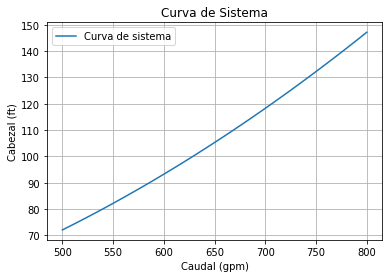

In [20]:
dz = z2 - z1

v = Q/A

Re = (fld.Reynolds(D=D, rho=rho, mu=mu, V=v)).to(u.dimensionless)

print(f"Número de Reynolds: {Re.magnitude}")

f = fld.friction.friction_factor(Re, eD=epsilon/D)

K_90_elbow = fld.fittings.bend_rounded_Crane(Di=D.magnitude, angle=90)
K_valve = fld.K_tilting_disk_check_valve_Crane(D=D.magnitude, angle = 5)

flow_rates = np.linspace(500, 800, 100)
velocities = (flow_rates*u.gallon/u.min).to(u.m**3/u.s) / A

total_head = dz + (f*L/D + 3*K_90_elbow + K_valve) * velocities**2 /(2*g)
total_head = (total_head).to(u.ft).magnitude

H_min = dz + (f*L/D + 3*K_90_elbow + K_valve) * (Q_min/A)**2 / (2*g)

print(f"Cabezal mínimo: {H_min.to(u.ft)}")

# plot curva de sistema
plt.plot(flow_rates, total_head, label='Curva de sistema')  # Convert flow rates to L/s for plot

# aspectos visuales
plt.xlabel('Caudal (gpm)')
plt.ylabel('Cabezal (ft)')
plt.title('Curva de Sistema')
plt.legend()
plt.grid(True)
plt.show()

b. Select a Series e-1531 Bell & Gossett pump for this system.

Considerando los rangos requeridos para el caudal (mínimo 500 gpm) y el mínimo correspondiente de cabezal que se calculó (72.10 ft), escogimos el modelo 3AD a 3550 RPM de la serie e-1531 Bell & Gossett (obtenido de la página 55 del archivo "Pump Curves - Penoncello"), siendo que en el rango de interés su curva de operación se asemeja a la curva de sistema calculada en la parte (a.).

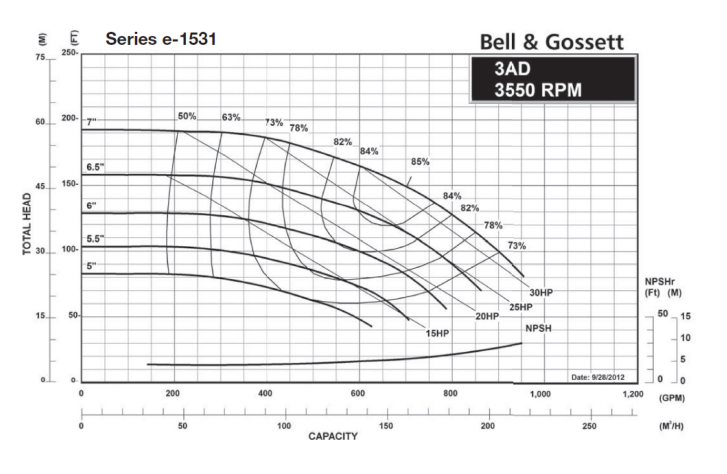

In [21]:
# plt pixmap for image
plt.figure(dpi=150)  # You can set it to any value you prefer, such as 200 or 300
plt.imshow(plt.imread("Curve e-1531 B&G.png"))
plt.axis('off')
plt.show()

c. What is the operating point of the pump/pipe system based on the pump you
selected in (b)? Specify the capacity (gpm), head (ft), brake horsepower input
to the pump (hp), and efficiency of the pump.

Observando las curvas de la bomba, se puede operar a aproximadamente 700 gpm con una eficiencia de 78%. En este punto de operación generaría 20 HP y un cabezal de aproximadamente 95 ft.

## Problema 3

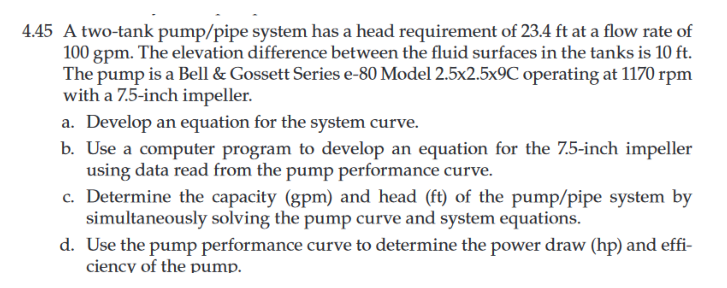

In [15]:
# plt pixmap for image
plt.figure(dpi=150)  # You can set it to any value you prefer, such as 200 or 300
plt.imshow(plt.imread("P3.png"))
plt.axis('off')
plt.show()

In [16]:
Hp_1 = 23.4*u.ft
Q_1 = 100*u.gallon/u.min

dz = 10*u.ft

a. Develop an equation for the system curve.

Dados los datos iniciales del problema, se sabe que:

$$\Delta z = z_2 - z_1 = 10 \text{ ft}$$
$$H_p (\dot{\forall} = 100 \text{ gpm}) = 23.4 \text{ ft}$$

Dada la ecuación modificada de Bernoulli, se sabe que la curva del sistema será de la forma:

$$H_p(\dot{\forall}) = \Delta z + C \dot{\forall}^2$$

Resolviendo, se tiene que:

$$23.4 = 10 + C \times 100^2$$

In [17]:
C = (Hp_1 - dz)/Q_1**2
print(C.magnitude)

0.0013399999999999998


Por lo tanto, se tiene que la ecuación sería finalmente:

$$H_p (\dot{\forall}) = 0.00134 \dot{\forall}^2 + 10 \text{ ft}$$

b. Use a computer program to develop an equation for the 7.5-inch impeller
using data read from the pump performance curve.

c. Determine the capacity (gpm) and head (ft) of the pump/pipe system by
simultaneously solving the pump curve and system equations.

d. Use the pump performance curve to determine the power draw (hp) and efficiency
of the pump.

## Problema 4

Considere el plano hidráulico de la localidad de Hualañé. Establezca un código computracional que
permita optimizar lls diámetros de tuberñia de la red hidráulica considerada en la Tarea 1. El objetivo de la optimización es que la diferencia de presiones enre las acometidas de las casas sea lo menor posible,
siempre considerando que la presión debe ser mayor a lo establecido por la nomrma de sistemas sanitarios. 

Considerando el caso extremo, cuando todas las casas tienen una llave de lavamanos abierta, determine el cabezal que debería sumiinistrar el sistema de bombreo.

## Referencias
[1] https://www.pipeflow.com/pipe-pressure-drop-calculations/pipe-roughness
